In [1]:
# fix python path if working locally
from helpers import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.utils.missing_values import fill_missing_values
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

import datetime as dt

import requests
import io

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)


c:\Users\lunar\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Importing Training Set
def loadDataset(url):
    s=requests.get(url).content
    dataset = data=pd.read_csv(io.StringIO(s.decode('utf-8')))
    dataset.livingroom_window_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.livingroom_door_open = dataset.livingroom_window_open.replace({True: 1, False: 0})
    dataset.balcony_door_open = dataset.livingroom_door_open.replace({True: 1, False: 0})
    dataset.kitchen_window_open = dataset.kitchen_window_open.replace({True: 1, False: 0})
    dataset.timestamp = pd.Series([dt.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ') for date in list(dataset['timestamp'])]).round("10S")

    # Select features (columns) to be involved intro training and predictions
    cols = ["timestamp", "co2","livingroom_window_open", "livingroom_door_open", "balcony_door_open", "kitchen_window_open"]
    return dataset[cols].drop_duplicates(subset=['timestamp'], keep='last')

dataset = loadDataset("https://iaq-data.brgr.rocks/full.csv")
print(dataset.tail)

<bound method NDFrame.tail of                  timestamp     co2  livingroom_window_open  \
0      2022-05-03 16:12:40  606.62                       0   
1      2022-05-03 16:12:50  605.24                       0   
2      2022-05-03 16:13:00  604.32                       0   
3      2022-05-03 16:13:10  604.82                       0   
4      2022-05-03 16:13:20  606.36                       0   
...                    ...     ...                     ...   
471123 2022-07-04 04:00:00  695.69                       1   
471124 2022-07-04 04:00:10  696.29                       1   
471125 2022-07-04 04:00:20  696.27                       1   
471126 2022-07-04 04:00:30  696.56                       1   
471127 2022-07-04 04:00:40  696.44                       1   

        livingroom_door_open  balcony_door_open  kitchen_window_open  
0                          0                  0                    0  
1                          0                  0                    0  
2           

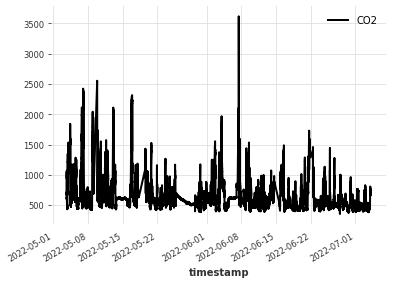

In [3]:
series_livingroom_door_open = TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_door_open', fill_missing_dates=True, freq="10s")
series_balcony_door_open = TimeSeries.from_dataframe(dataset, 'timestamp', 'balcony_door_open', fill_missing_dates=True, freq="10s")
series_co2 = TimeSeries.from_dataframe(dataset, 'timestamp', 'co2', fill_missing_dates=True, freq="10s" )
series_livingroom_door_open = fill_missing_values(series_livingroom_door_open, fill='auto')
series_balcony_door_open = fill_missing_values(series_livingroom_door_open, fill='auto')
series_co2 = fill_missing_values(series_co2, fill='auto')

series_co2.plot(label="CO2")

plt.legend()


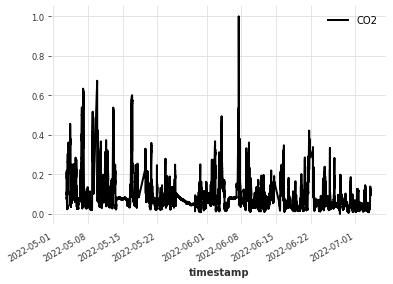

In [4]:
scaler = Scaler()
series_co2_scaled, series_livingroom_door_open_scaled, series_balcony_door_open_scaled = scaler.fit_transform([series_co2, series_livingroom_door_open, series_balcony_door_open])

series_co2_scaled.plot(label="CO2")
plt.legend()

In [5]:
train_co2 = series_co2_scaled[:-36]
train_livingroom_door_open = series_livingroom_door_open_scaled[:-36]
train_balcony_door_open = series_balcony_door_open_scaled[:-36]

print(train_co2)

<TimeSeries (DataArray) (timestamp: 531253, component: 1, sample: 1)>
array([[[0.07708268]],

       [[0.07665974]],

       [[0.07637778]],

       ...,

       [[0.10497232]],

       [[0.10491103]],

       [[0.10498458]]])
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2022-05-03T16:12:40 ... 2022-07-04T...
  * component  (component) object 'co2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


In [7]:
model_co2 = BlockRNNModel(
    model="LSTM",
    input_chunk_length=180,
    output_chunk_length=180,
    n_epochs=1,
    random_state=0,
    dropout=0.1,
    model_name="LSTM",
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    force_reset=True,

)




In [9]:
model_co2.fit([train_co2, train_livingroom_door_open, train_balcony_door_open], verbose=True)



2022-07-04 07:01:40 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 530894 samples.
2022-07-04 07:01:40 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-07-04 07:01:40 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-07-04 07:01:40 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-07-04 07:01:40 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-07-04 07:01:40 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 4.7 K 
---------------------------------------------------
7.5 K     Trainable params
0       

Epoch 0:   0%|          | 82/16591 [00:06<21:48, 12.62it/s, loss=0.00079, train_loss=0.000299] 8]

Epoch 0:   0%|          | 82/16591 [00:23<1:17:30,  3.55it/s, loss=0.00079, train_loss=0.000299]

In [226]:
dataset = loadDataset("https://iaq-data.brgr.rocks/day.csv")

series_livingroom_door_open = TimeSeries.from_dataframe(dataset, 'timestamp', 'livingroom_door_open', fill_missing_dates=True, freq="10s")
series_balcony_door_open = TimeSeries.from_dataframe(dataset, 'timestamp', 'balcony_door_open', fill_missing_dates=True, freq="10s")
series_co2 = TimeSeries.from_dataframe(dataset, 'timestamp', 'co2', fill_missing_dates=True, freq="10s" )
series_livingroom_door_open = fill_missing_values(series_livingroom_door_open, fill='auto')
series_balcony_door_open = fill_missing_values(series_livingroom_door_open, fill='auto')
series_co2 = fill_missing_values(series_co2, fill='auto')

scaler = Scaler()
series_co2_scaled, series_livingroom_door_open_scaled, series_balcony_door_open_scaled = scaler.fit_transform([series_co2, series_livingroom_door_open, series_balcony_door_open])

series_co2_scaled.plot(label="CO2")
plt.legend()


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, -79274.42it/s]   


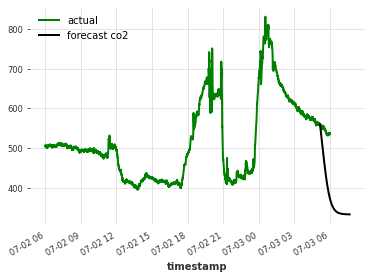

In [225]:

position = 1200
past = 900
train_co2 = series_co2_scaled[-position:-(position-past)]
train_livingroom_door_open = series_livingroom_door_open_scaled[-position:-(position-past)]
train_balcony_door_open = series_balcony_door_open_scaled[-position:-(position-past)]

actual_co2 = series_co2_scaled #[-position:-(position-90)]

pred_list_scaled = model_co2.predict(n=past, series=[train_co2, train_livingroom_door_open, train_balcony_door_open])

pred_list = scaler.inverse_transform(pred_list_scaled)
series_air = scaler.inverse_transform(series_co2_scaled)
series_actual = scaler.inverse_transform(actual_co2)

series_actual.plot(label="actual", color="green")
for series, label in zip(pred_list, ["co2"]):
    series.plot(label=f"forecast {label}")
plt.legend()
